# 랜덤 포레스트(Random Forest)
- 랜덤 포레스트는 앙상블 알고리즘 중 비교적 빠른 수행 속도를 가지고 있으며, 다양한 영역에서 높은 예측 성능을 보이고 있다.
- 기반 알고리즘은 결정 트리이다.
- 여러개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측 결정을 하게 된다.
- 개별적인 분류기의 기반 알고리즘은 결정 트리이지만 개별 트리가 학습하는 데이터 세트는 전체 데이터에서 일부가 중첩되게 샘플링된 데이터 세트이다. 이렇게 여러개의 데이터 세트를 중첩되게 분리하는 것을 부트스트래핑(bootstrapping)분할 방식이라고 한다. (그래서 bagging이 bootstrap aggregating의 줄임말이다)
- 이렇게 데이터가 중첩된 개별 데이터 세트에 결정 트리 분류기를 각각 적용하는 것이 랜덤 포레스트이다.

# 사용자 행동 인식 데이터 셋을 RandomForestClassifier로 예측

- 재수행 할때마다 동일한 예측 결과를 출력하기 위해 RandomForestClassifier의 random_state를 0으로 설정

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [7]:
# 중복된 피처 이름 바꾸기
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                 columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how="outer")
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                              'dup_cnt']].apply(lambda x : x[0] + '_' + str(x[1]) 
                                                                                if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [8]:
# 데이터셋을 구성하는 함수 설정
def get_human_dataset():
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백문자를 sep으로 할당
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', 
                                  header=None, names=['column_index', 'column_name'])
    # 데이터프레임에 피처명을 컬럼으로 뷰여하기 위해 리스트 객체로 다시 반환
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # 데이터프레임에 피처명을 칼럼으로 부여하기 위해 리스트로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    # 학습 피처 데이터셋과 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name
    X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', 
                          header=None, names=feature_name)
    X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', 
                          header=None, names=feature_name)
    
    y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', 
                          header=None, names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', 
                          header=None, names=['action'])
    #로드된 학습/테스트용 데이터 DataFrame 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [9]:
# get_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9196


## 랜덤 포레스트 하이퍼 파라미터 및 튜닝

- n_estimators: 트리를 몇 개 만들 것인지 (int, default=10), 값이 클수록 오버피팅 방지
- criterion: gini 또는 entropy 중 선택
- max_depth: 트리의 깊이 (int, default=None)
- bootstrap: True이면 전체 feature에서 복원추출해서 트리 생성 (default=True)
- max_features: 선택할 feature의 개수, 보통 default값으로 씀 (default='auto')

## GridSearchCV를 이용해 랜덤 포레스트의 하이퍼 파라미터를 튜닝하기

In [12]:
from sklearn.model_selection import GridSearchCV

params={'max_depth':[8,16,24],
        'min_samples_leaf':[1,6,12],
        'min_samples_split':[2,8,16]}

# randomforestclassifier 객체 생성 후 grdisearchcv수행
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train,y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도:0.9165


In [13]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16,
                                 min_samples_split=2, random_state=0)
rf_clf1.fit(X_train,y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도:{0:.4f}'.format(accuracy_score(y_test,pred)))

예측 정확도:0.9260


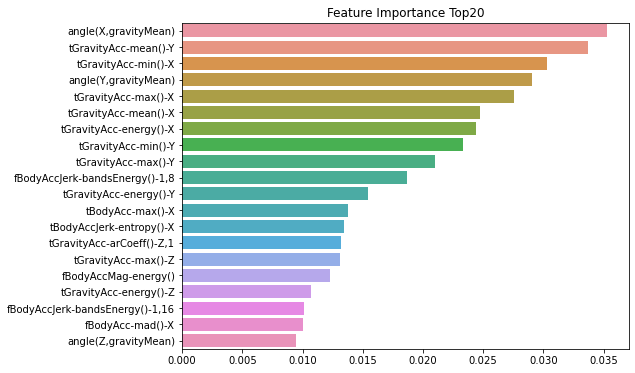

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importance_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importance_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importance Top20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# GridSearchCV 실습 예제

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

iris_data = load_iris()
label = iris_data.target
data = iris_data.data

X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.2)


# GridSearchCV의 param_grid 설정
params = {
    'max_depth': [2, 3],
    'min_samples_split': [2, 3]
}

dtc = DecisionTreeClassifier()

grid_tree = GridSearchCV(dtc, param_grid=params, cv=3, refit=True)
grid_tree.fit(X_train, y_train)

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)
em = grid_tree.best_estimator_
pred = em.predict(X_val)
accuracy_score(y_val, pred)

best parameters :  {'max_depth': 2, 'min_samples_split': 2}
best score :  0.9416666666666668


0.9333333333333333